In [ ]:
#https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
#!pip install graphviz
#!conda install --yes -c conda-forge graphviz

# Minimal example to get `dask.distributed` working

* No `dask_geopandas` installed in `dask.distributed`...will have to ask Andrew. For now, test `dask.dataframe` only.
* Move all functions into this notebook to simplify for now.
* Read in multiple tabular datasets, merge, and do aggregation.
* Get task graph loaded (`bus_service_utils` has the `pip` and `conda` requirements)
* Can we test `dask.delayed` and `dask futures`?

In [1]:
import dask.dataframe as dd
import pandas as pd

#from dask.distributed import Client

analysis_date = "2022-10-12"
RT_GCS = 'gs://calitp-analytics-data/data-analyses/rt_delay/cached_views/'

In [2]:
def import_data(itp_id, date):
    stop_times = dd.read_parquet(
                f"{RT_GCS}st_{itp_id}_{date}.parquet")
    trips = dd.read_parquet(
        f"{RT_GCS}trips_{itp_id}_{date}.parquet")
    
    return stop_times, trips

In [3]:
def categorize_time_of_day(value: int ) -> str:
    if isinstance(value, int):
        hour = value
    if hour < 4:
        return "Owl"
    elif hour < 7:
        return "Early AM"
    elif hour < 10:
        return "AM Peak"
    elif hour < 15:
        return "Midday"
    elif hour < 20:
        return "PM Peak"
    else:
        return "Evening"

In [4]:
def merge_stop_times_to_trips(stop_times: dd.DataFrame, 
                          trips: dd.DataFrame) -> dd.DataFrame:   
    shape_id_cols = ["calitp_itp_id", "shape_id"]

    merged = dd.merge(
        stop_times,
        trips[shape_id_cols + ["trip_id"]].drop_duplicates(),
        on = ["calitp_itp_id", "trip_id"]
    )
    
    # Map to time-of-day
    stop_times_binned = merged.assign(
        time_of_day=merged.apply(
            lambda x: categorize_time_of_day(x.departure_hour), axis=1, 
            meta=('time_of_day', 'str'))
    )
    
    # Calculate the number of arrivals by time-of-day
    arrivals = (stop_times_binned.groupby(shape_id_cols + ["time_of_day"])
          .agg({"stop_id": "count"})
            .reset_index()
         )
    
    return arrivals

In [5]:
# In the script, it's looping over list of operators,
# and importing just the operator's data, merging, and giving outputs.
def my_function(itp_id: int, analysis_date: str) -> dd.DataFrame:
    stop_times, trips = import_data(itp_id, analysis_date)   

    # Merge routelines to trips, and drop shape_ids that are 
    # giving the same info (in terms of route_length, direction_id)
    merged = merge_stop_times_to_trips(stop_times, trips)
    
    return merged

In [ ]:
client = Client("dask-scheduler.dask.svc.cluster.local:8786")
client

Show task graph for just 1 operator.

* low-level: `.visualize()` 
* high-level: `.dask.visualize()`

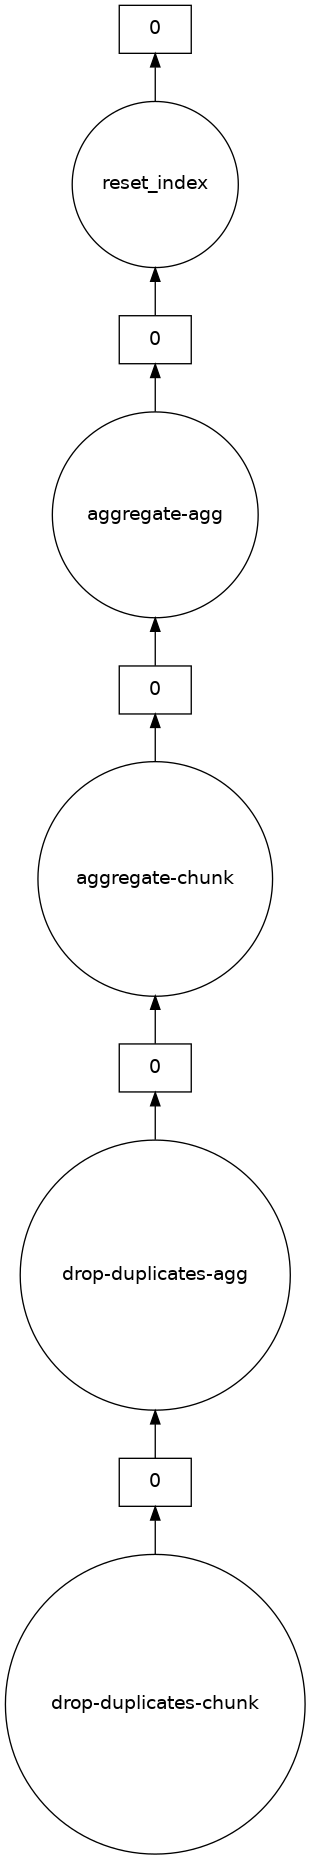

In [6]:
# Low-level graph
my_function(183, analysis_date).visualize(optimize_graph=True)

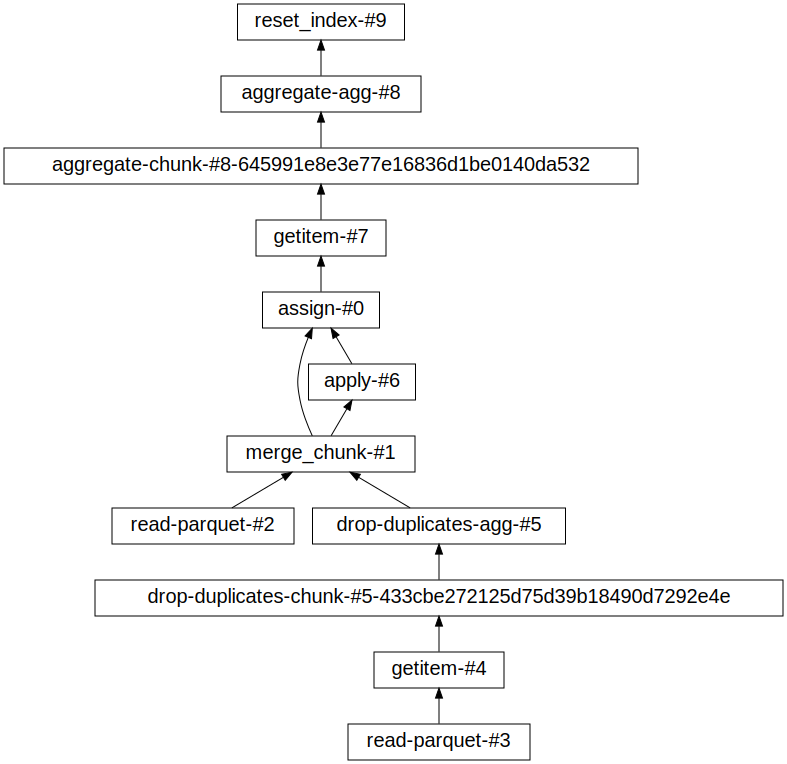

In [7]:
# high-level graph
my_function(183, analysis_date).dask.visualize()

In [8]:
def import_data_combined(date):
    RT_GCS = 'gs://calitp-analytics-data/data-analyses/rt_delay/compiled_cached_views/'
    stop_times = dd.read_parquet(f"{RT_GCS}st_{date}.parquet")
    trips = dd.read_parquet(f"{RT_GCS}trips_{date}.parquet")
    
    return stop_times, trips

In [9]:
all_stop_times, all_trips = import_data_combined(analysis_date)

In [10]:
all_stop_times = all_stop_times.repartition(npartitions=5)
all_trips = all_trips.repartition(npartitions=5)

In [11]:
merged = merge_stop_times_to_trips(all_stop_times, all_trips)

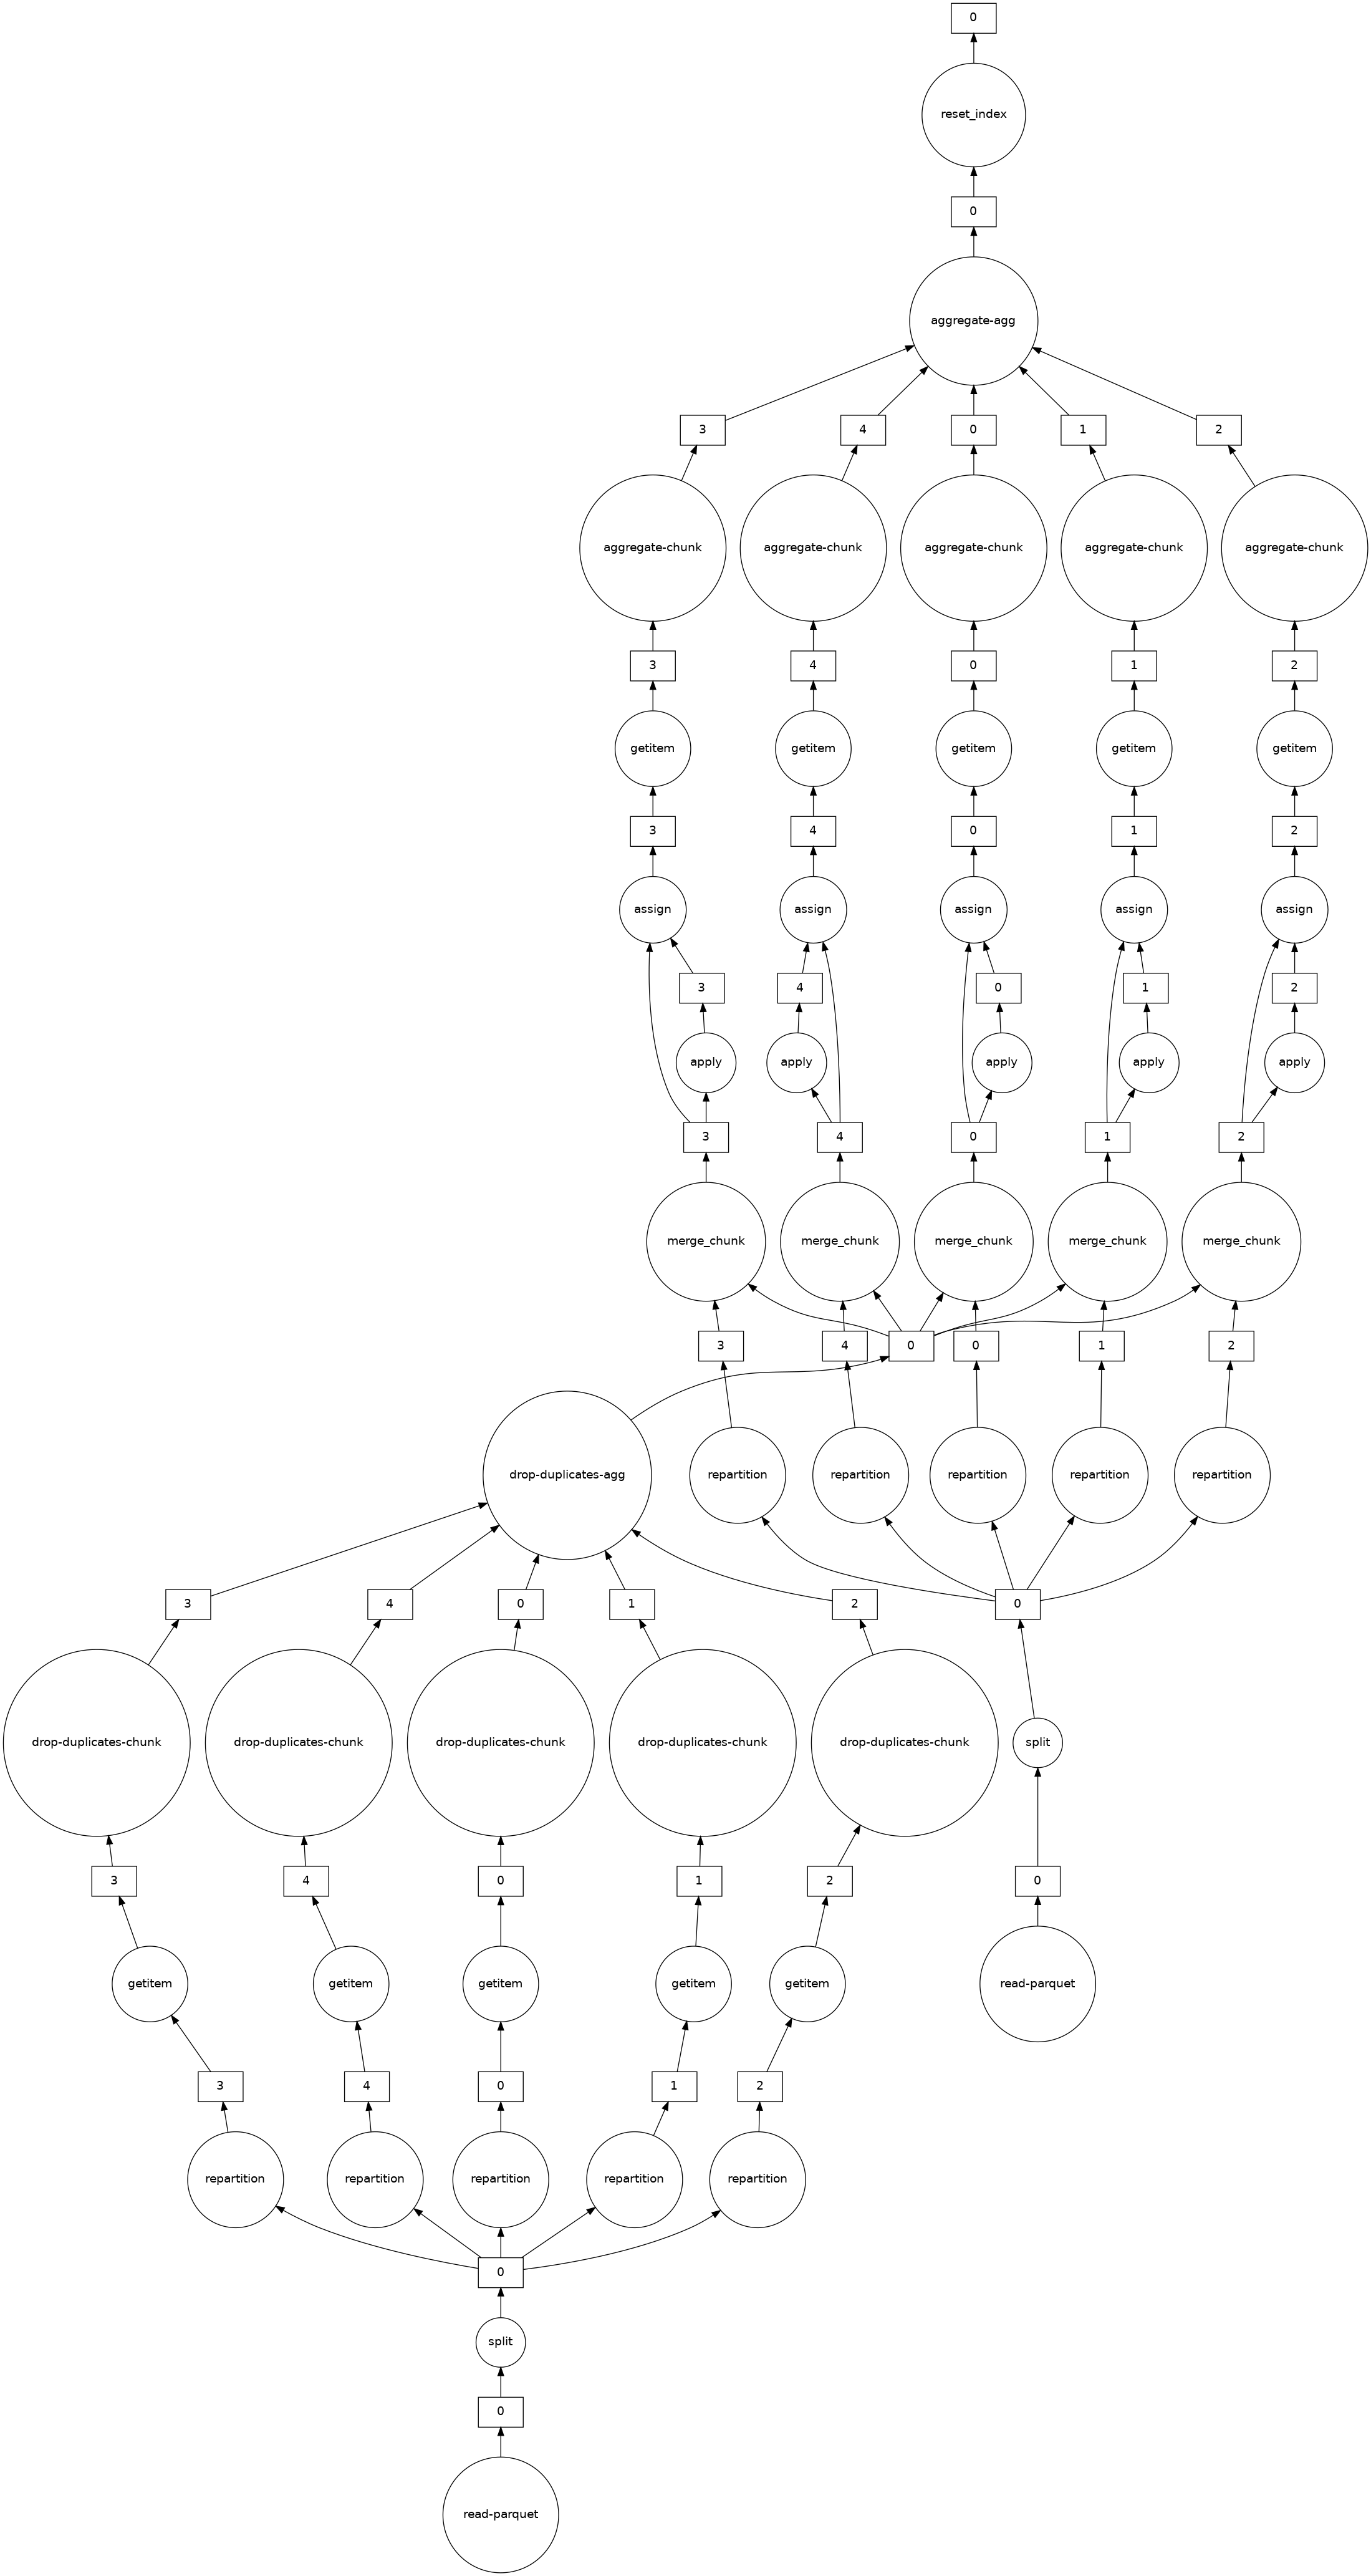

In [12]:
merged.visualize()

In [13]:
merged.to_parquet("gs://calitp-analytics-data/data-analyses/dask_test/test.parquet")

In [14]:
merged.calitp_itp_id.unique().compute().tolist()

[4,
 6,
 10,
 11,
 14,
 15,
 16,
 17,
 18,
 24,
 29,
 30,
 34,
 35,
 36,
 37,
 42,
 45,
 48,
 49,
 50,
 56,
 61,
 70,
 71,
 75,
 76,
 77,
 79,
 81,
 82,
 83,
 86,
 87,
 95,
 98,
 99,
 101,
 102,
 103,
 105,
 106,
 107,
 108,
 110,
 112,
 116,
 117,
 120,
 121,
 122,
 123,
 126,
 127,
 129,
 135,
 137,
 142,
 146,
 148,
 152,
 154,
 159,
 162,
 165,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 176,
 177,
 178,
 179,
 181,
 182,
 183,
 187,
 188,
 190,
 194,
 198,
 201,
 204,
 206,
 207,
 208,
 210,
 214,
 217,
 218,
 220,
 221,
 226,
 228,
 231,
 232,
 235,
 238,
 239,
 243,
 246,
 247,
 251,
 257,
 259,
 260,
 261,
 264,
 269,
 270,
 271,
 273,
 274,
 278,
 279,
 280,
 281,
 282,
 284,
 287,
 289,
 290,
 293,
 294,
 295,
 296,
 298,
 300,
 301,
 305,
 308,
 310,
 312,
 314,
 315,
 320,
 323,
 324,
 329,
 331,
 334,
 336,
 337,
 339,
 343,
 344,
 346,
 349,
 350,
 351,
 356,
 360,
 361,
 366,
 367,
 368,
 372,
 374,
 376,
 380,
 381,
 386,
 389,
 473,
 474,
 481,
 482,
 483,
 484,
 